In [2]:
!pip install librosa

   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/1.0 MB 16.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import librosa
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from glob import glob

In [3]:
NORMAL_DIR = "data/normal"
ANOM_DIR_BROKEN = "data/anomaly/broken"
ANOM_DIR_HL = "data/anomaly/heavyload"

print("Normal files:", len(glob(NORMAL_DIR + "/*.wav")))
print("Broken anomaly files:", len(glob(ANOM_DIR_BROKEN + "/*.wav")))
print("Heavyload anomaly files:", len(glob(ANOM_DIR_HL + "/*.wav")))

Normal files: 105
Broken anomaly files: 124
Heavyload anomaly files: 128


In [4]:
def extract_mfcc(path, n_mfcc=40):
    y, sr = librosa.load(path, sr=16000)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc = mfcc.T
    return mfcc

In [5]:
class SoundDataset(Dataset):
    def __init__(self, file_list):
        self.files = file_list

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        mfcc = extract_mfcc(self.files[idx])
        mfcc = torch.tensor(mfcc, dtype=torch.float32)
        return mfcc

In [6]:
normal_files = glob(NORMAL_DIR + "/*.wav")
broken_files = glob(ANOM_DIR_BROKEN + "/*.wav")
heavy_files = glob(ANOM_DIR_HL + "/*.wav")

anomaly_files = broken_files + heavy_files

print("Normal:", len(normal_files))
print("Anomalies:", len(anomaly_files))

train_dataset = SoundDataset(normal_files)
test_dataset_normal = SoundDataset(normal_files[:20])
test_dataset_anom = SoundDataset(anomaly_files[:20])

Normal: 105
Anomalies: 252


In [7]:
class AE(nn.Module):
    def __init__(self, feature_dim=40, hidden_dim=16):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(feature_dim, 32),
            nn.ReLU(),
            nn.Linear(32, hidden_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, feature_dim)
        )
    
    def forward(self, x):
        z = self.encoder(x)
        out = self.decoder(z)
        return out

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
model = AE().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

EPOCHS = 20
losses = []

for epoch in range(EPOCHS):
    total_loss = 0
    for mfcc in train_loader:
        mfcc = mfcc.squeeze(0).to(device)
        
        recon = model(mfcc)
        loss = criterion(recon, mfcc)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    avg = total_loss / len(train_loader)
    losses.append(avg)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss = {avg:.4f}")

Using device: cpu
Epoch 1/20, Loss = 441.5019
Epoch 2/20, Loss = 7.7960
Epoch 3/20, Loss = 7.6311
Epoch 4/20, Loss = 7.4309
Epoch 5/20, Loss = 7.7093
Epoch 6/20, Loss = 7.4598
Epoch 7/20, Loss = 7.3546
Epoch 8/20, Loss = 7.2041
Epoch 9/20, Loss = 6.6527
Epoch 10/20, Loss = 6.3075
Epoch 11/20, Loss = 6.3167
Epoch 12/20, Loss = 6.1708
Epoch 13/20, Loss = 6.1835
Epoch 14/20, Loss = 6.0445
Epoch 15/20, Loss = 6.0452
Epoch 16/20, Loss = 5.9534
Epoch 17/20, Loss = 5.9243
Epoch 18/20, Loss = 5.6852
Epoch 19/20, Loss = 5.6217
Epoch 20/20, Loss = 5.5961


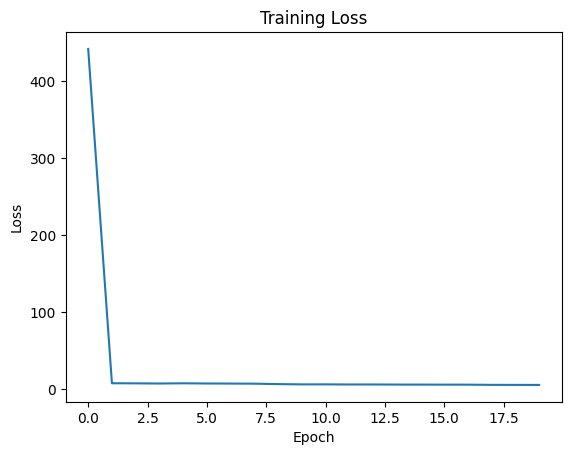

In [9]:
plt.plot(losses)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [10]:
def anomaly_score(model, mfcc):
    mfcc = torch.tensor(mfcc, dtype=torch.float32).to(device)
    recon = model(mfcc)
    loss = torch.mean((recon - mfcc)**2).item()
    return loss

In [11]:
normal_scores = []
for path in normal_files[:20]:
    mfcc = extract_mfcc(path)
    normal_scores.append(anomaly_score(model, mfcc))

anomaly_scores = []
for path in anomaly_files[:20]:
    mfcc = extract_mfcc(path)
    anomaly_scores.append(anomaly_score(model, mfcc))

print("Avg Normal Score:", np.mean(normal_scores))
print("Avg Anomaly Score:", np.mean(anomaly_scores))

Avg Normal Score: 6.383025765419006
Avg Anomaly Score: 238.46584930419922


In [12]:
threshold = np.mean(normal_scores) * 1.5

print("Threshold:", threshold)

for i, path in enumerate(anomaly_files[:10]):
    score = anomaly_score(model, extract_mfcc(path))
    prediction = "ANOMALY" if score > threshold else "NORMAL"
    print(f"{os.path.basename(path)} → Score={score:.4f} → {prediction}")

Threshold: 9.57453864812851
pure_0.wav → Score=242.4525 → ANOMALY
pure_1.wav → Score=245.4756 → ANOMALY
pure_10.wav → Score=245.7337 → ANOMALY
pure_100.wav → Score=237.5073 → ANOMALY
pure_101.wav → Score=237.4268 → ANOMALY
pure_102.wav → Score=236.6839 → ANOMALY
pure_103.wav → Score=237.8143 → ANOMALY
pure_104.wav → Score=235.6276 → ANOMALY
pure_105.wav → Score=236.6979 → ANOMALY
pure_106.wav → Score=237.5810 → ANOMALY


In [13]:
def get_score(path):
    mfcc = extract_mfcc(path)
    return anomaly_score(model, mfcc)

all_normal_scores = [get_score(p) for p in normal_files]
all_anom_scores   = [get_score(p) for p in anomaly_files]

y_true = []
y_pred = []

for s in all_normal_scores:
    y_true.append(0)
    y_pred.append(0 if s <= threshold else 1)

for s in all_anom_scores:
    y_true.append(1)
    y_pred.append(0 if s <= threshold else 1)

from sklearn.metrics import classification_report, confusion_matrix

print("Confusion matrix (rows=true, cols=pred):")
print(confusion_matrix(y_true, y_pred))

print("\nClassification report:")
print(classification_report(y_true, y_pred, target_names=["normal", "anomaly"]))

Confusion matrix (rows=true, cols=pred):
[[103   2]
 [  0 252]]

Classification report:
              precision    recall  f1-score   support

      normal       1.00      0.98      0.99       105
     anomaly       0.99      1.00      1.00       252

    accuracy                           0.99       357
   macro avg       1.00      0.99      0.99       357
weighted avg       0.99      0.99      0.99       357



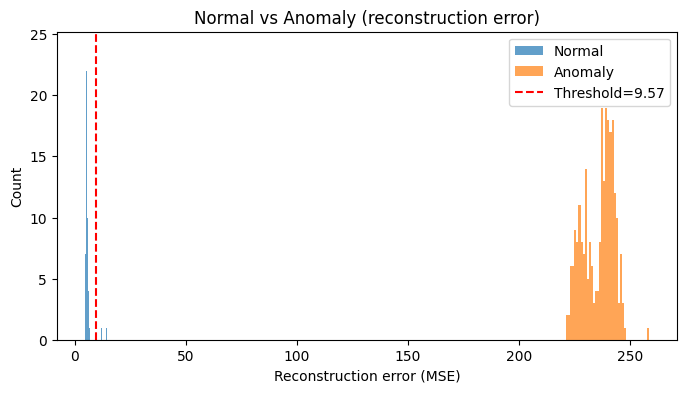

In [14]:
plt.figure(figsize=(8,4))
plt.hist(all_normal_scores, bins=40, alpha=0.7, label="Normal")
plt.hist(all_anom_scores, bins=40, alpha=0.7, label="Anomaly")
plt.axvline(threshold, color="red", linestyle="--", label=f"Threshold={threshold:.2f}")
plt.xlabel("Reconstruction error (MSE)")
plt.ylabel("Count")
plt.title("Normal vs Anomaly (reconstruction error)")
plt.legend()
plt.show()